#图片的二值化

![Scan0001.png](img/Scan0001.png)

先来看一张报纸上的图片，如果你觉得它有什么特殊含义那你想多了，这是我随手拿的一张报纸然后扫描的。扫描过程中，先设定为24位彩色图像，然后利用`convert`命令进行旋转后将colorspace设定为Gray，然后裁剪并压缩转换为png格式。

下图为右上角的灯笼

![Scan0001_crop.png](img/Scan0001_crop.png)

你可以看到灯笼上有明显的黑点而不是数字图像放大后出现的均匀色彩变化的特点。这是因为打印机只能控制某个点上是否要染墨水，而不能决定一个点上需要多少墨水。无论是喷墨还是激光打印机都是如此。这看似限制了我们对于色彩的表达，但我们可以充分利用视觉的局限性——人眼只能分辨大于一定视角的细节而对于这个视角以内的细节无法分辨——来表达一幅连续而均匀的图像。当我们将许多细小的点混在一个肉眼无法分辨的地方时，大脑就会误以为这就是一个点，而我们所感知的这一点的色彩即为这些小点所产生的混合色。这一混色过程有别于颜色转盘实验中的时间混合，被称为空间混合。彩色电视、计算机显示器都运用了这一原理，但与打印不同，这些显示设备的像素点的三原色发光强度可以被设定为一系列的数值，而不是两种状态。另外，值得注意的是，人眼分辨细节的能力由视角这一概念判断，因此单位面积内可以“欺骗”人眼的最少点数与观看距离成反比。设计中观看距离较远的媒介，如大型LED广告牌，单位面积上的点数就可以少一些。

在日常打印过程中，电脑会自动处理好这样的二值化转换，但现在让我们一起探讨一下这一过程背后的原理。先来看一下我们所需要的外部包：`plt`用于在显示图片，`mpimg`用于图片的输入与输出，最后，`numpy`用于处理数学计算。注意：由`mpimg`读入的图像像素为取值范围是\[0, 1\]的浮点数，所以有时我们需要乘上255并取整来确保算法正常运行。导出图片时，请注意`plt.imshow`函数只能为我们提供预览来验证算法是否工作，如果要查看最终成果，应该使用`plt.imsave`函数导出。如下图这是Bayer抖动算法结果用`imsave`保存的结果，可以说与下文的`imshow`结果是天壤之别。另外，建议检查照片查看器是否存在插值处理（放大后观察像素是方块状还是形成了有梯度的小圆点），如果没有找到合适的查看器，可以下载gimp编辑器中查看。

![bayer_result.png](img/bayer_result.png)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

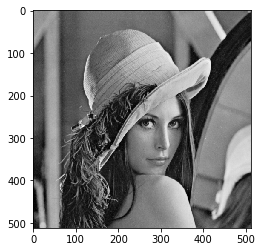

In [2]:
lena = mpimg.imread('img/lena_std.png')
lena = np.dot(lena[..., :], [0.2126, 0.7152, 0.0722])
plt.imshow(lena, cmap='gray')

##50%阈值法
一种非常直接，非常Naive的方式便是直接将亮度值低于0.5的设为0，超过0.5的像素设为1，这样做造成了大面积黑色区域以及白色区域，也就造成了图像中明暗细节的丢失。

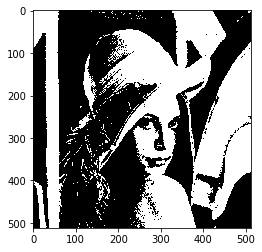

In [3]:
lena_1 = lena.copy()
lena_1[lena_1 < 0.5] = 0
lena_1[lena_1 >=0.5] = 1
plt.imshow(lena_1, cmap='gray')

##抖动技术

###模式抖动
模式抖动中最具代表性的是柯达工程师Bayer在1973年依前人改进的方法，因此人们往往把模式抖动称为Bayer抖动。Bayer抖动也用到阈值，不过它用的是一张阈值矩阵，也叫作抖动矩阵。在生成阈值矩阵后将像素值超过阈值矩阵中元素值的结果设为1，反之设为0。很多情况下，图像尺寸会比阈值矩阵大，此时就要将阈值矩阵通过不断复制的方法向右及向下拓展直至阈值矩阵尺寸大于图像，但这里我们将采用取模的方法确定像素在阈值矩阵中对应的位置来减少计算。

生成阈值矩阵的递归过程可以参阅维基百科上对[模式抖动的介绍](https://en.wikipedia.org/wiki/Ordered_dithering)。在这里，我们使用的是8乘8的阈值矩阵。由于此方阵中元素取值范围是\[0, 63\]（63位整数），我们需要将8位的灰度图像的后2位截取。虽然损失了精度但视觉效果还是可行的。从结果可以看到（在数字显示设备上建议尝试调整图片大小后观看），相比于50%阈值法，这种方法保留了右侧镜子、肩膀上的灰度。但它的局限性在于将同一种模式应用于整幅图片，略作放大就可以看到许多排列整齐的`×`型图案。

In [4]:
def bayer_pattern(n):
    # n必须为2的次幂，此处省略对n的合法性检查
    if n == 1:
        return np.array([0])
    else:
        result = np.empty([n, n])
        bayer_low = bayer_pattern(n // 2)
        ones = np.ones([n//2, n//2])
        result[:n//2, :n//2] = 4 * bayer_low
        result[:n//2, n//2:] = 4 * bayer_low + 2 * ones
        result[n//2:, :n//2] = 4 * bayer_low + 3 * ones
        result[n//2:, n//2:] = 4 * bayer_low + ones
        return result

In [5]:
bayer_diffusion_matrix = bayer_pattern(8)
bayer_diffusion_matrix

array([[ 0., 32.,  8., 40.,  2., 34., 10., 42.],
       [48., 16., 56., 24., 50., 18., 58., 26.],
       [12., 44.,  4., 36., 14., 46.,  6., 38.],
       [60., 28., 52., 20., 62., 30., 54., 22.],
       [ 3., 35., 11., 43.,  1., 33.,  9., 41.],
       [51., 19., 59., 27., 49., 17., 57., 25.],
       [15., 47.,  7., 39., 13., 45.,  5., 37.],
       [63., 31., 55., 23., 61., 29., 53., 21.]])

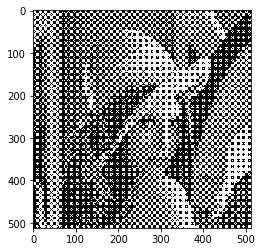

In [6]:
lena_2 = lena.copy()
lena_2 = 255 * lena_2
lena_2 = lena_2.astype(np.int)
def bin_right_move(n):
    return n >> 2
lena_2 = np.vectorize(bin_right_move)(lena_2)

for i in range(lena_2.shape[0]):
    for j in range(lena_2.shape[1]):
        x = i % 8
        y = j % 8
        if lena_2[i, j] > bayer_diffusion_matrix[x, y]:
            lena_2[i, j] = 1.0
        else:
            lena_2[i, j] = 0.0
plt.imshow(lena_2, cmap='gray')

###误差扩散抖动
为了减少Bayer抖动产生的规则化图形，我们可以采取误差扩散方法。此方法的核心为将每个像素在二值化中将产生的误差按一定比例分配到其他还未处理的像素上。这可以说是阈值法的一种改进，即将无规则噪声加入到处理过程中。我们先确定一个矩阵来表达误差分配的比例，然后在每一行上的每一像素进行阈值比较并分配误差。这里我们介绍两种分配方案：第一种是1975年由Floyd-Steinberg提出的过滤器，也叫误差分配表，第二种是Stucki过滤器。Stucki是前一种方案的改进，但由于增加了过滤器的大小，自然也造成了速度慢的缺陷。

实现过程中，为了避免边界情况的讨论，我们可以将原图像四周填充`0`，不过这需要索引值的转换。《计算机色彩原理及应用》中介绍，抖动处理时可采用螺旋型扫描的方案（先从左到右，下一行再从右到左，循环往复），但经过实验（将下文函数中`i % 2 == 0`的判断条件直接换为`True`）这似乎并没有起到太大效果。还要注意，这种螺旋型扫描中在从右往左的过程中应该左右反转`mat`，否则无法将误差传递给同一行上左边的像素。此外，为了提高效果，可以借用`cv2`模块中的`resize`函数将图像放大后再处理，尽管关于图像信息量可以说没有增加，但效果确实出奇的好。

![error_diff_lar.png](img/error_diff_lar.png)

没错，原图放大后就是黑点和白点。

In [7]:
def FS_diffusion(img, mat):
    # mat应为n×n的矩阵，且n为奇数，此处省略检查
    img_x, img_y = img.shape
    mat_x, mat_y = mat.shape
    im_ex = np.zeros([img_x + 2*(mat_x//2),
                      img_y + 2*(mat_y//2)])
    im_ex[mat_x//2: -(mat_x//2), mat_y//2: -(mat_y//2)] = img
    new_im = np.empty([img_x, img_y])

    for i in range(img_x):
        for j in range(img_y):
            _i = i + mat_x//2
            if i % 2 == 0:
                _j = j + mat_x//2
                _mat = mat
            else:
                _j = img_y - j - 1 + mat_y//2
                _mat = mat[:,::-1]
            if im_ex[_i, _j] >= 0.5:
                error = im_ex[_i, _j] - 1
                new_im[i, _j - mat_y//2] = 1.0
            else:
                error = im_ex[_i, _j] - 0
                new_im[i, _j - mat_y//2] = 0.0
            im_ex[_i - mat_x // 2: _i + mat_x // 2 + 1,
                  _j - mat_y // 2: _j + mat_y // 2 + 1] +=\
            error * _mat
    return new_im

In [8]:
diffuse_matrix = np.array([[0, 0, 0],
                           [0, 0, 7],
                           [3, 5, 1]]) / 16

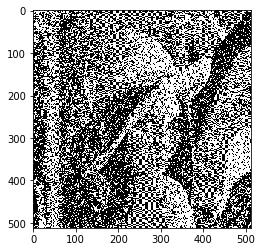

In [9]:
lena_3 = lena.copy()
lena_3 = FS_diffusion(lena_3, diffuse_matrix)
plt.imshow(lena_3, cmap='gray')

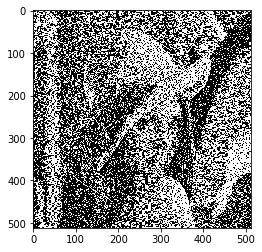

In [10]:
diffuse_matrix_l = np.array([[0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0],
                             [0, 0, 0, 8, 4],
                             [2, 4, 8, 4, 2],
                             [1, 2, 4, 2, 1]]) / 42
lena_3 = lena.copy()
lena_3 = FS_diffusion(lena_3, diffuse_matrix_l)
plt.imshow(lena_3, cmap='gray')

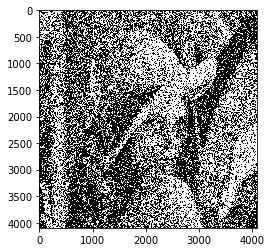

In [11]:
import cv2

lena_3 = lena.copy()
lena_3 = cv2.resize(lena_3, dsize=(4096, 4096))
lena_3 = FS_diffusion(lena_3, diffuse_matrix_l)
plt.imshow(lena_3, cmap='gray')